# Group 43 Project Proposal

### Predictors of Student Performance in School

For students, juggling high grades and a social life can be a stressful endeavor. Oftentimes students can overstudy for exams in order to achieve their desired grade. This leads to unneeded sacrifices being made in the other facets of a student's life. Performance in school often feels like a guessing game of whether you have put enough time into learning. Because of this, our group has decided to investigate how factors affect the performance of students in school . We are trying to answer the question: How can students spend their time more efficently to pass their classes? The data set we used is "Students Performance Data Set" compiled by Paulo Cortez, a professor at the Unversity of Minho in Portugal. This data set contains attributes about academic achievement, demographics, and the social and academic environment of a Portuguese language course, collected by survey in 2 Portuguese Secondary schools. 

### Preliminary Exploratory Data Analysis

In [5]:
# Required libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [8]:
# Reading the data set from the web into R
student_data <- read_delim("https://raw.githubusercontent.com/gpark8910/DSCI100_project/main/student-por.csv",
                          delim = ";") %>%
    select(traveltime, studytime, freetime, goout, G1, G2, G3) %>% # Details about our variables in "Methods"
    mutate(G3 = case_when(
       G3 <= 9 ~ "fail",
       G3 >= 10 ~ "pass"))
student_data

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



traveltime,studytime,freetime,goout,G1,G2,G3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2,2,3,4,0,11,pass
1,2,3,3,9,11,pass
1,2,3,2,12,13,pass
⋮,⋮,⋮,⋮,⋮,⋮,⋮
2,2,1,1,11,12,fail
2,1,4,5,10,10,pass
3,1,4,1,10,11,pass


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



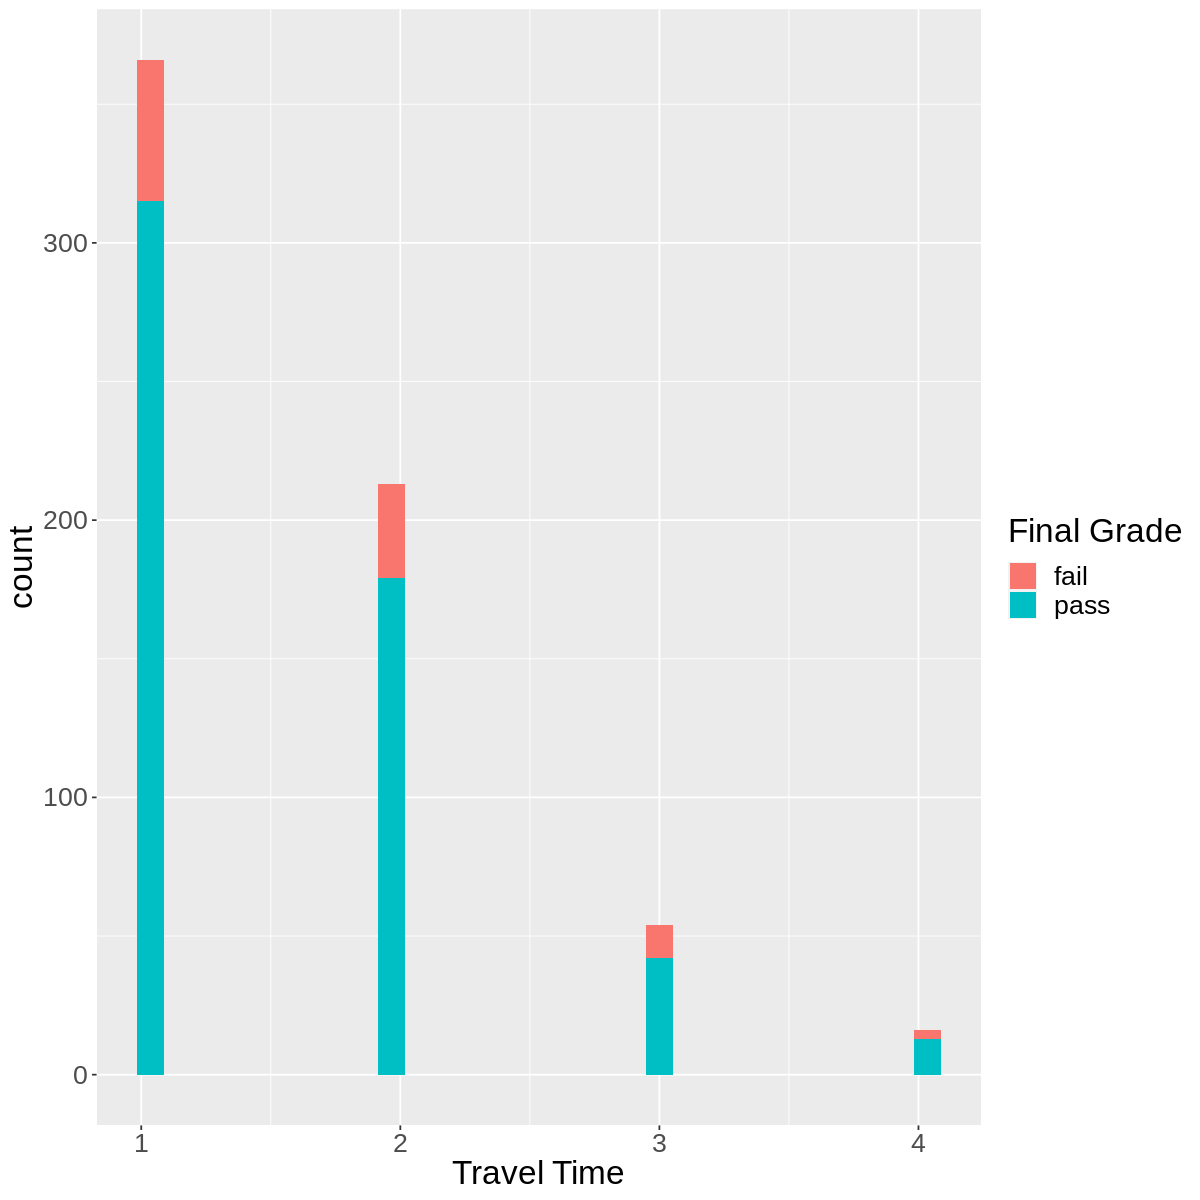

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



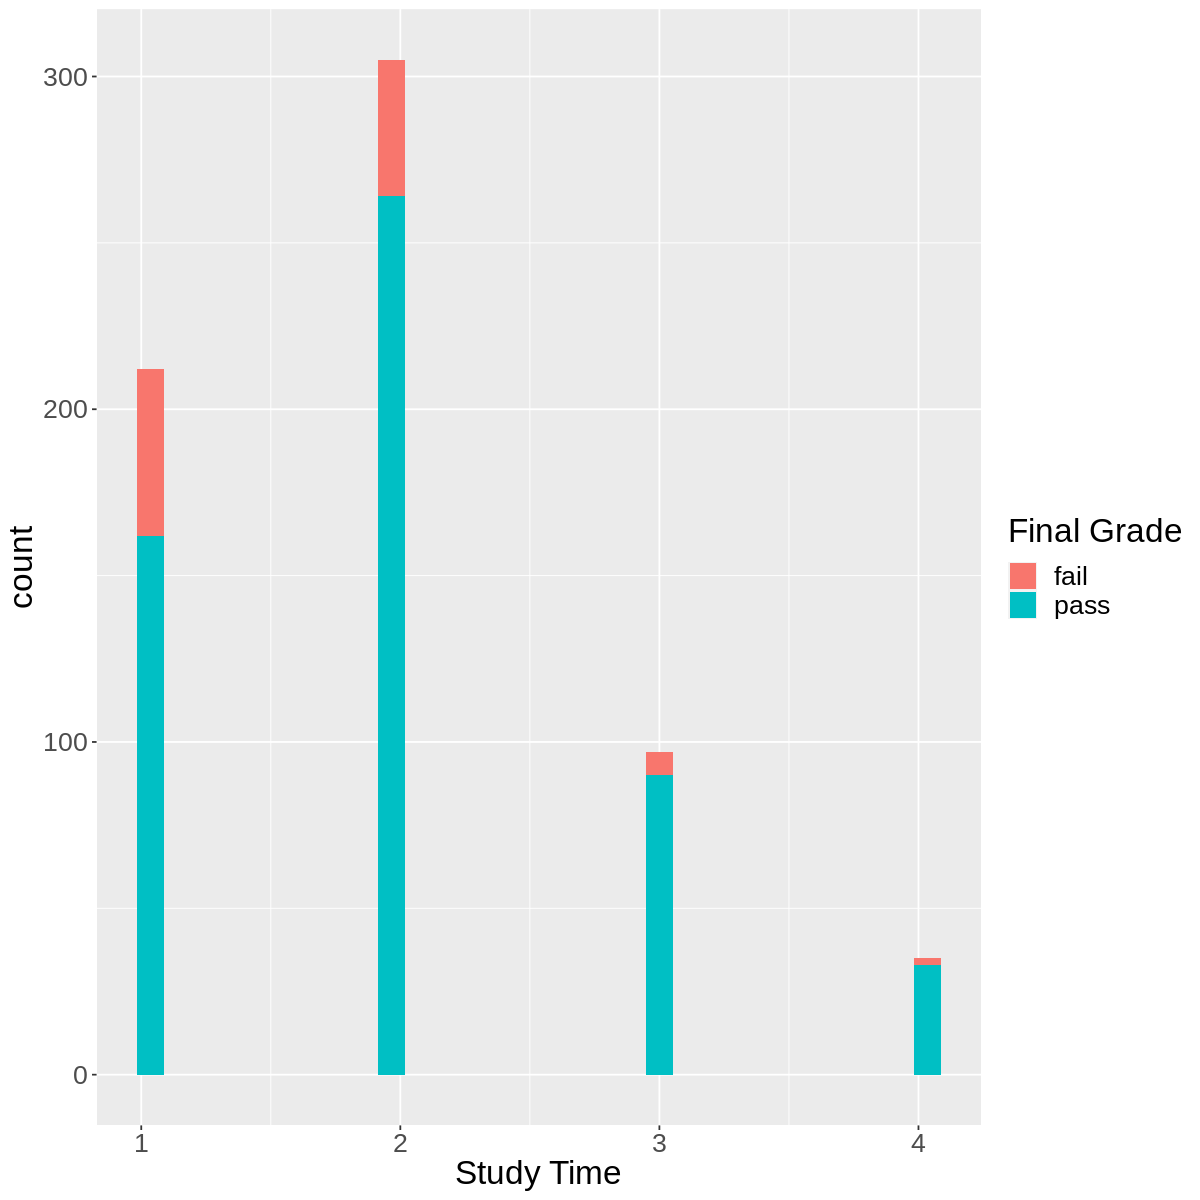

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



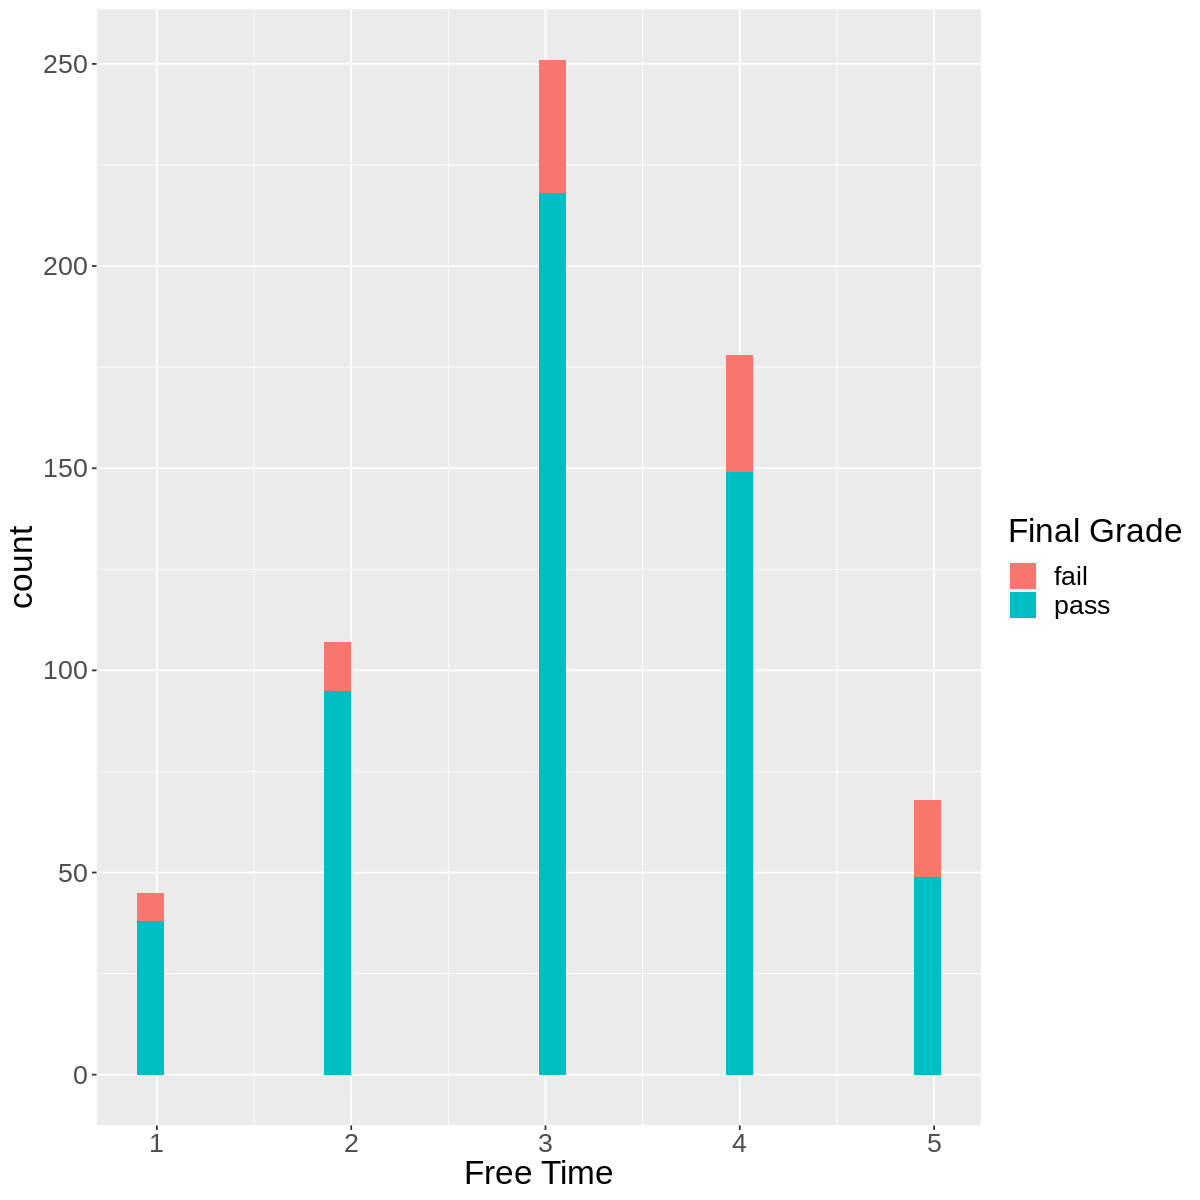

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



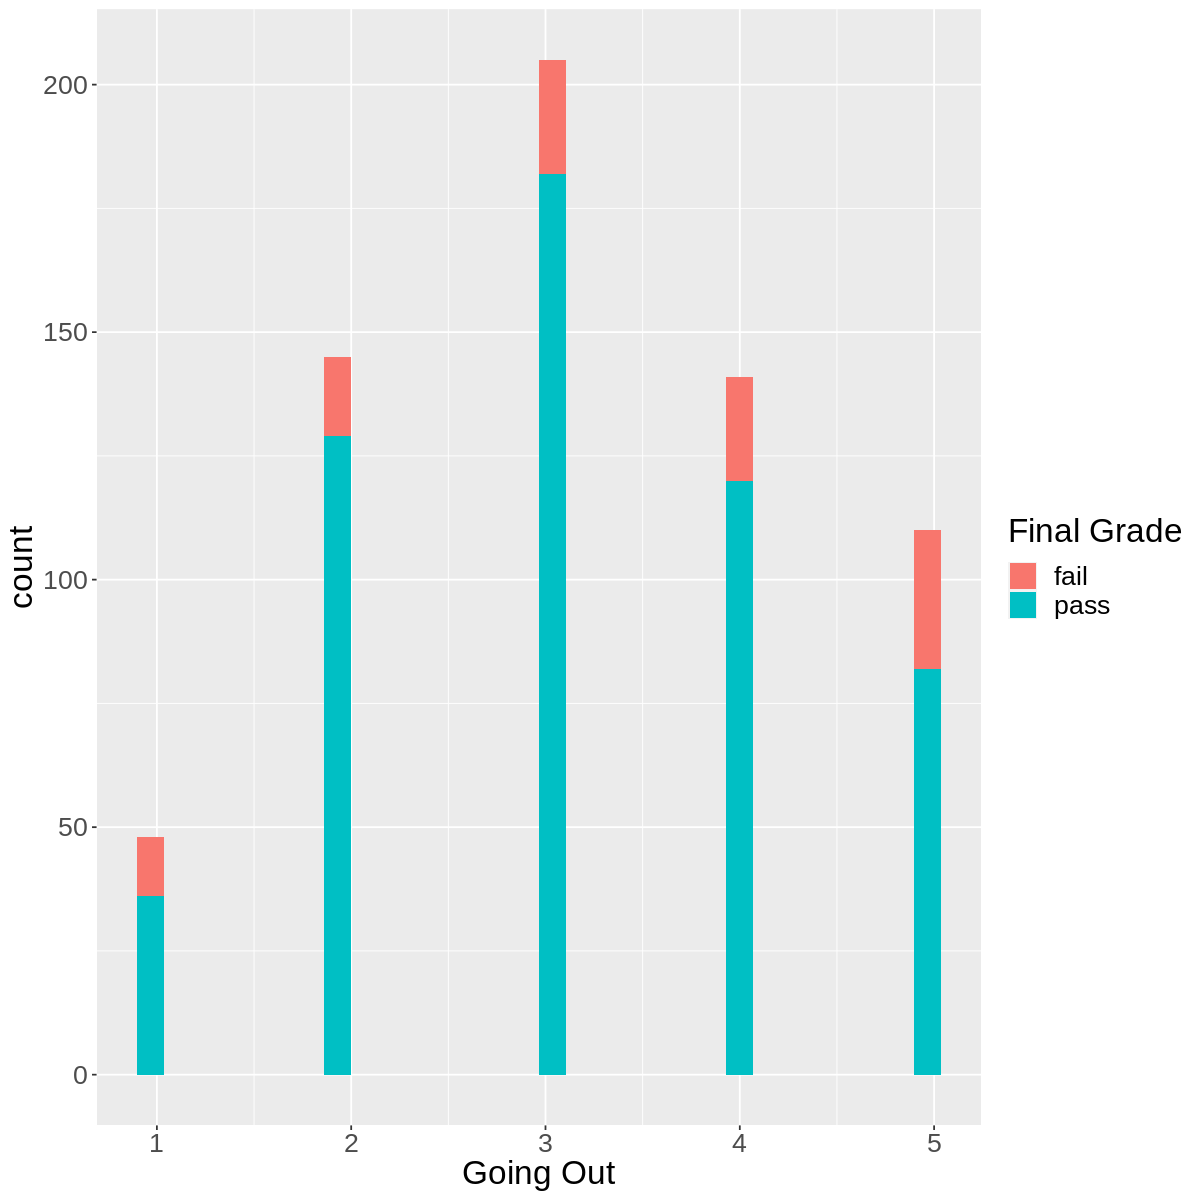

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



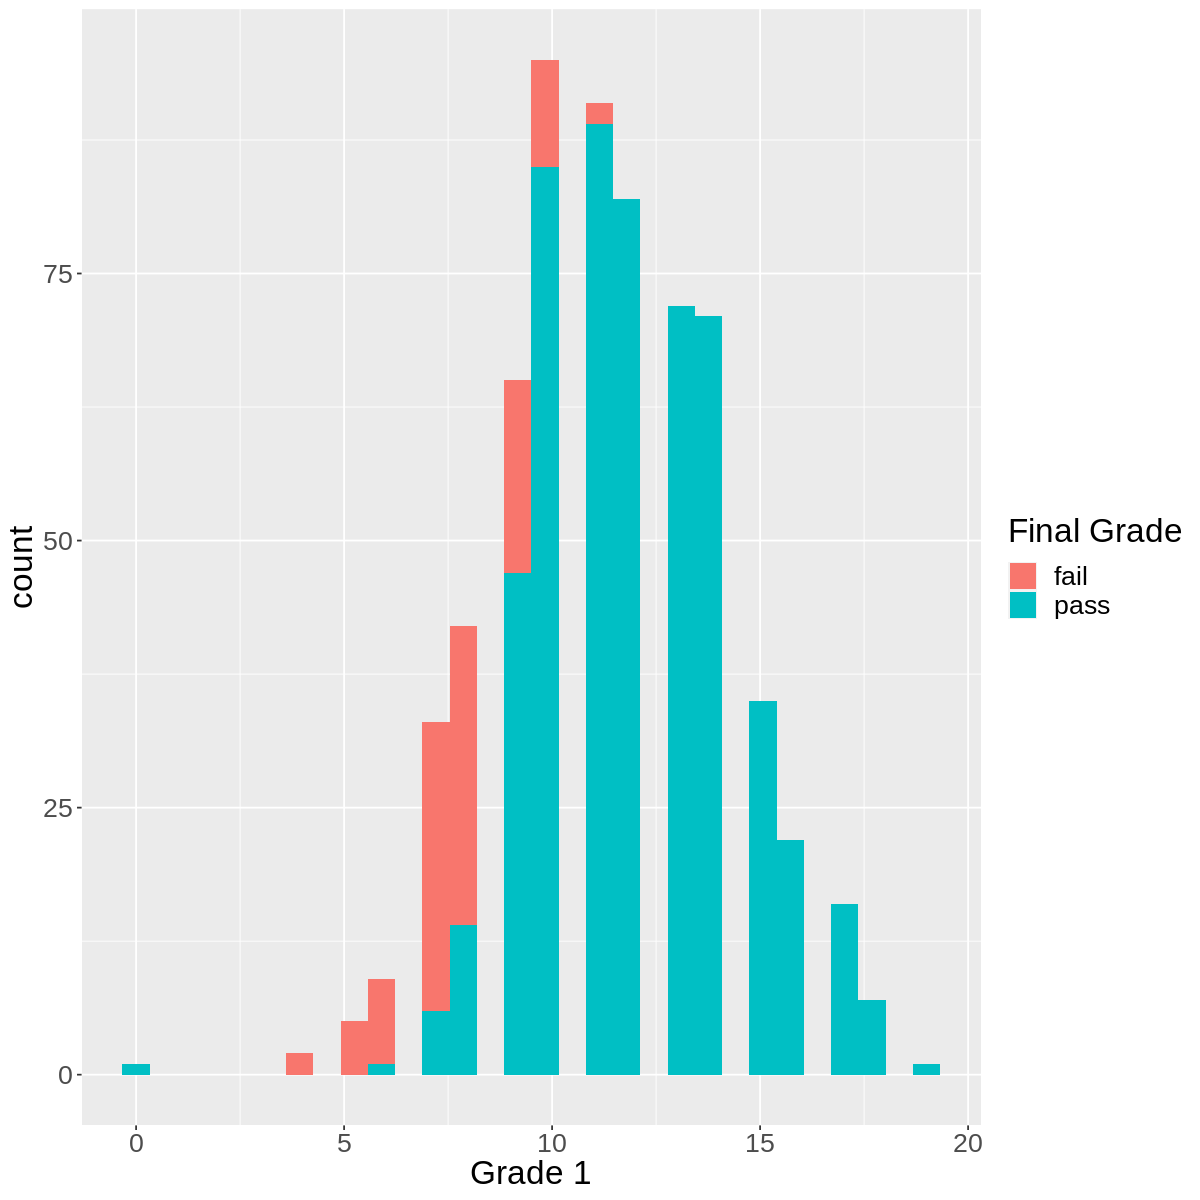

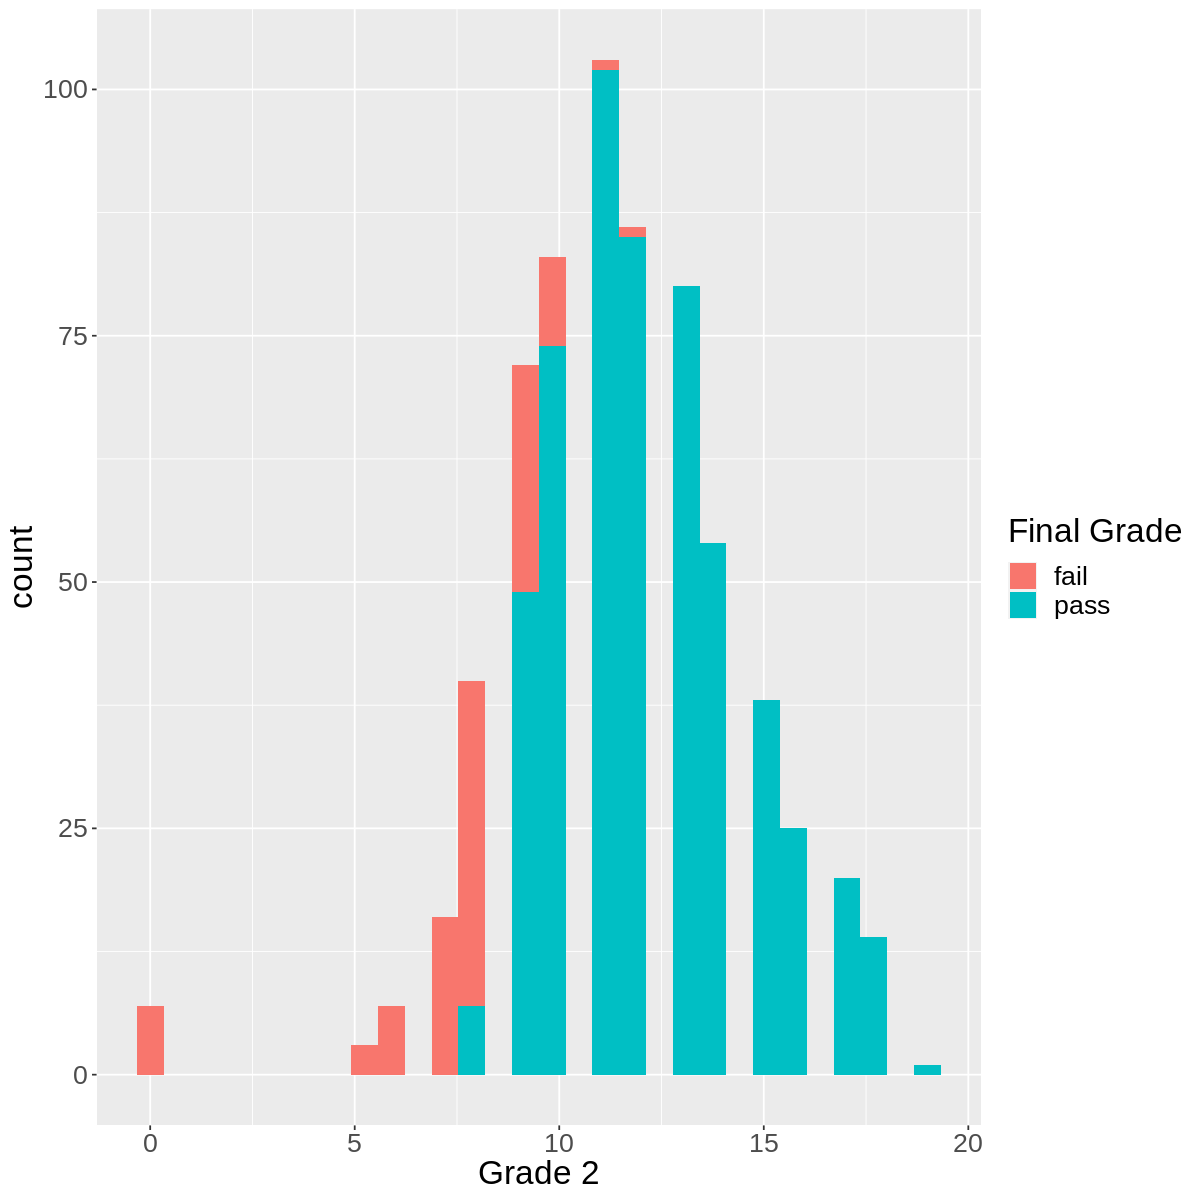

In [7]:
#create visualization for the data
options(repr.plot.width = 10, repr.plot.height = 10) 

travel_time_distribution <- student_data %>% 
   ggplot(aes(x = traveltime, fill = G3)) +
   geom_histogram() +
   labs(x = "Travel Time", fill = "Final Grade") +
   theme(text = element_text(size = 20))

travel_time_distribution

study_time_distribution <- student_data %>% 
   ggplot(aes(x = studytime, fill = G3)) +
   geom_histogram() +
   labs(x = "Study Time", fill = "Final Grade") +
   theme(text = element_text(size = 20))

study_time_distribution

free_time_distribution <- student_data %>% 
   ggplot(aes(x = freetime, fill = G3)) +
   geom_histogram() +
   labs(x = "Free Time", fill = "Final Grade") +
   theme(text = element_text(size = 20))

free_time_distribution

goout_time_distribution <- student_data %>% 
   ggplot(aes(x = goout, fill = G3)) +
   geom_histogram() +
   labs(x = "Going Out", fill = "Final Grade") +
   theme(text = element_text(size = 20))

goout_time_distribution

grade_1_distribution <- student_data %>% 
   ggplot(aes(x = G1, fill = G3)) +
   geom_histogram() +
   labs(x = "Grade 1", fill = "Final Grade") +
   theme(text = element_text(size = 20))

grade_1_distribution

grade_2_distribution <- student_data %>% 
   ggplot(aes(x = G2, fill = G3)) +
   geom_histogram() +
   labs(x = "Grade 2", fill = "Final Grade") +
   theme(text = element_text(size = 20))

grade_2_distribution

## Methods

We have selected 6 predictors for our study to predict the final grade of students.
* Travel Time: Time spent travelling between home and school
* Study Time: Weekly time spent studying
* Free Time: Free time after school
* Go Out: Going out with friends
* G1: First period grade
* G2: Second period grade
* G3: Final grade

Since G3 had such a wide range, we regrouped it into two classes, fail or pass. A final grade of 0-9 would equal a failing grade, and 10-20 would equal to a passing grade. To reclassify column G3, we used a new function called case_when.

We plan to use histograms to visualize our data.

## Expected Outcomes and Significance
We expect to see a positive relationship between the amount of time spent studying and the proportion of students that pass the class. This relationship holds true for period 1 and period 2 grades as well. As a student's period 1 and period 2 grades increase, the likelihood that they pass the course also increases. We also expect to see a negative relationship between the amount of time a student does not spend studying (the amount of time a student has to commute to school, the amount of free time a student has, and the amount of time a student goes out with their freinds) and the proportion of students that pass the class. The impact of this finding would mean that students have to sacrfice personal free-time in order to achieve higher grades and pass their courses. However this leads to a different question. How would a student find a balance between study and leisure time that would allow them to not only acheive a passing grade but also allow the student to engage in extracuricular and social activities?